-------------------------------

In [1]:
import pandas as pd

df = pd.read_csv('dataset/train_data.txt', sep=" ::: ", header=None)

df.drop([0], axis=1, inplace=True)
df.rename(columns={1: 'title', 2: 'genre', 3: 'description'}, inplace=True)
df = df[["title", "description", "genre"]]

C:\Users\Kamil\AppData\Local\Temp\ipykernel_6900\2958472327.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('dataset/train_data.txt', sep=" ::: ", header=None)


In [2]:
df.sample(5)

,title,description,genre
16575,Tilbage til Bagdad (2003),While the United States and it's allies aim th...,documentary
9264,Providence (1977),Clive Langham (Sir John Gielgud) spends one to...,drama
50164,Vance and Pepe (2011),In this mockumentary special based on characte...,comedy
43428,"""Young@Art"" (2013)",Young@Art is a 9-part documentary series about...,documentary
11257,"""Strip Search"" (2001)","Search for six of New Zealand's sexiest men, l...",documentary


In [3]:
df['genre'].unique()

array(['drama', 'thriller', 'adult', 'documentary', 'comedy', 'crime',
       'reality-tv', 'horror', 'sport', 'animation', 'action', 'fantasy',
       'short', 'sci-fi', 'music', 'adventure', 'talk-show', 'western',
       'family', 'mystery', 'history', 'news', 'biography', 'romance',
       'game-show', 'musical', 'war'], dtype=object)

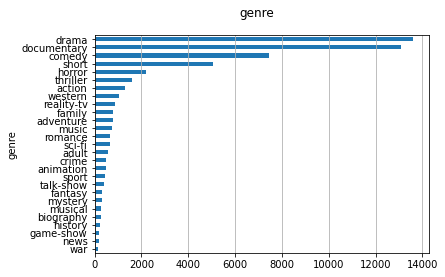

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.suptitle("genre", fontsize=12)
df["genre"].reset_index().groupby("genre").count().sort_values(by="index").plot(kind="barh", legend=False, ax=ax).grid(axis='x')
plt.show()

In [5]:
import nltk, re

def preprocess_sentence(text, stemm=False, lemm=True, stopwords=None): # process one sentence
    # lowercase -> strip -> tokenize -> remove stopwords -> stemm / lemm -> untokenize 

    # lower & strip
    text = text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    # tokenize (convert from string to list)
    text_tokens = text.split()
    
    # remove garbage
    text_tokens = [word.lower().strip('!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') for word in text_tokens]

    # remove stopwords
    if stopwords is not None:
        text_tokens = [word for word in text_tokens if word not in stopwords]
                
    ## stemming
    if stemm:
        ps = nltk.stem.porter.PorterStemmer()
        text_tokens = [ps.stem(word) for word in text_tokens]
                
    # lemmatisation 
    if lemm:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        text_tokens = [lem.lemmatize(word) for word in text_tokens]
        
    # back to string from list
    text = " ".join(text_tokens)
    
    return text

def preprocess_text(text, stopwords): 
    
    # split sentences 
    sentences = text.split('.')
    
    # process each sentence
    sentences = [preprocess_sentence(s, stopwords=stopwords) for s in sentences]
    
    result = ". ".join(sentences)
    return result
    

In [84]:
nltk_stopwords = nltk.corpus.stopwords.words("english")
nltk_stopwords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [7]:
df['description'][2]

'As the bus empties the students for their field trip to the Museum of Natural History, little does the tour guide suspect that the students are there for more than just another tour. First, during the lecture films, the coeds drift into dreams of the most erotic fantasies one can imagine. After the films, they release the emotion of the fantasies in the most erotic and uncommon ways. One slips off to the curator\'s office for a little "acquisition. " Another finds the anthropologist to see what bones can be identified. Even the head teacher isn\'t immune. Soon the tour is over, but as the bus departs, everyone admits it was quite an education.'

In [8]:
preprocess_text(df['description'][2], stopwords=nltk_stopwords)

'bus empty student field trip museum natural history little tour guide suspect student another tour. first lecture film coeds drift dream erotic fantasy one imagine. film release emotion fantasy erotic uncommon way. one slip curator office little acquisition. another find anthropologist see bone identified. even head teacher isnt immune. soon tour bus departs everyone admits quite education. '

In [9]:
df["processed"] = df["description"].apply(lambda x: preprocess_text(x, stopwords=nltk_stopwords))

In [10]:
df.head()

,title,description,genre,processed
0,Oscar et la dame rose (2009),Listening in to a conversation between his doc...,drama,listening conversation doctor parent 10yearold...
1,Cupid (1997),A brother and sister with a past incestuous re...,thriller,brother sister past incestuous relationship cu...
2,"Young, Wild and Wonderful (1980)",As the bus empties the students for their fiel...,adult,bus empty student field trip museum natural hi...
3,The Secret Sin (1915),To help their unemployed father make ends meet...,drama,help unemployed father make end meet edith twi...
4,The Unrecovered (2007),The film's title refers not only to the un-rec...,drama,film title refers unrecovered body ground zero...


In [11]:
from sklearn import model_selection

# split dataset
df_train, df_test = model_selection.train_test_split(df, test_size=0.3)
# get target
y_train = df_train["genre"].values
y_test = df_test["genre"].values

Cały zbiór dostaje nową kolumne preprocessed. Żeby ją otrzymać każdy opis dzielony jest na sentencje a każda sentencja tokenizowana na słowa. Z tych słów usuwane sa wszystkie niepotrzebne znaki aby poprawnie usunąć słowa bez znaczenia (stopwords) i aby poprawnie przeporowadzona została lematyzacja. Później sentencje zbite są ponownie w opisy. 

Teraz taki zbiór podzielony jest na test i train

### Prepare corpus for word2vec training [training set]


In [12]:
processed = df_train["processed"]

def tokenize_text(text_or_path, file_input=False): # find better solution for large scale texts (batch reading from os)
   
   text = ''
   if file_input:
      with open(text_or_path) as f:
         text = f.read()
         text = text.replace('\n', '')
   else:
      text = text_or_path
         
   # tokenize text to sentences
   sentences = text.split(sep='.')
   sentences = [s.strip() for s in sentences]
   
   # tokenize sentences to words
   sentences_tokenized = [s.split(sep=' ') for s in sentences]
   
   #for i, s in enumerate(sentences_tokenized):
   #   sentences_tokenized[i] = [word.lower().strip('!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') for word in s]
      
   return sentences_tokenized

# tokenize all joined preprocessed descriptions
corpus_tokenized = tokenize_text(''.join(processed))
corpus_tokenized[0]

['simpson',
 'scribe',
 'dana',
 'gould',
 'written',
 'untitled',
 'multicamera',
 'comedy',
 'star']

In [13]:
len(processed)

37949

In [14]:
len(corpus_tokenized)

196229

## PREPARE NEW DESCRIPTION COLUMN FOR TRAINING.

In [15]:
processed = df_train["processed"]

def multi_sentence_to_one(multi_sen_arr, file_input=False): # find better solution for large scale texts (batch reading from os)

    return [multi_sen.replace('.', ' ') for multi_sen in multi_sen_arr]

# tokenize all joined preprocessed descriptions
processed_as_sentences = multi_sentence_to_one(processed)
len(processed_as_sentences)
processed_as_sentences[1]

'one popular influential female rb group time pointer sister combined influence jazz soul gospel scat pop sometimes even country music winning amalgam  continue perform enduring new song maintain devoted following concert recorded april 2004 alberta bair theatre billing montana  feature recent lineup consisting ruth anita ruth daughter issa group play enduring hit  set list includes fairytale chain fool yes im excited among many others  '

In [16]:
df["desc_prepared"] = df["processed"].apply(lambda x: x.replace('.', ' '))

In [17]:
descriptions_corpus = '.'.join(df["desc_prepared"])

fitting word2vec

Następnie bierzemy treningową część zbioru i przeprocesowane wcześniej opisy łączymy w jeden długi tekst i dzielimy na same słowa. Te słowa następnie dodajemy do modelu Word2Vec, który nauczy się ich znaczeń w kontekście sentencji w jakich się znajdują. Dokonana zostanie też redukcja wymiarowości do 300 cech.

Uczymy się na opisach przed zlączeniem powyżej aby słowa znajdowaly sie w swoich zdaniach - a nie w jednym dużym (caly opis)

In [18]:
from gensim.models import Word2Vec
nlp = None
load = True

#loading cell
if load:
    nlp = Word2Vec.load("word2vec.model")
else:
    nlp = Word2Vec(sentences=corpus_tokenized, vector_size=300, window=8, workers=4, sg=1, epochs=30) # sg: 1-skip gram 0-cbow
    nlp.save("word2vec.model")


In [19]:
nlp.wv['man'][:10]

array([-0.20275694,  0.09380215, -0.13456184, -0.02818538, -0.0982755 ,
       -0.13635966,  0.22474203,  0.28120387,  0.1179752 , -0.30947843],
      dtype=float32)

# visualisation

In [20]:
from sklearn import manifold



c:\source\ai-nlp\env\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\source\ai-nlp\env\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
C:\Users\Kamil\AppData\Local\Temp\ipykernel_6900\1038844405.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf_["input"].iloc[0:1] = 1


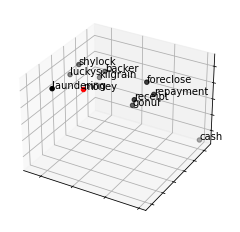

In [21]:
word = "money"
fig = plt.figure()
## word embedding
tot_words = [word] + [tupla[0] for tupla in nlp.wv.most_similar(word, topn=10)]
X = nlp.wv[tot_words]

## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)
## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1
## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

### TRANSFORM PREPROCESSED CORPUS INTO LIST OF SEQUENCES

Teraz stworzony zostanie słownik dla corpusu który powstał z opisów zbioru treningowego. W tym słowniku każde słowo z korpusu dostanie swój indeks. Następnie za pomocą tych indeksów przedstawione zostaną sentencje zawierające się w opisach.

In [22]:
df.processed

0        listening conversation doctor parent 10yearold...
1        brother sister past incestuous relationship cu...
2        bus empty student field trip museum natural hi...
3        help unemployed father make end meet edith twi...
4        film title refers unrecovered body ground zero...
                               ...                        
54209    shortlived nbc live sitcom centered bonino wor...
54210    next generation exploitation. sister kapa bay ...
54211    ze bestaan echt standup comedy growing facing ...
54212    walter vivian live country difficult time keep...
54213    labor day weekend 1935 intense hurricane ever ...
Name: processed, Length: 54214, dtype: object

In [23]:
from tensorflow.keras import preprocessing as k_preprocessing

# tokenize vocab
tokenizer = k_preprocessing.text.Tokenizer(lower=True, split=' ', oov_token="NaN", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(df_train.processed) # corpus_tokenized can be tested as well
dic_vocabulary = tokenizer.word_index

In [24]:
print(len(dic_vocabulary.keys()))

for key in list(dic_vocabulary.keys())[50:52]:
    print(key, dic_vocabulary[key])


110957
place 51
house 52


In [25]:
# create sequence of dictionary ids in place of words
lst_text2seq = tokenizer.texts_to_sequences(df_train.processed)
lst_text2seq[4]
len(lst_text2seq)

37949

Trzeba też dalej zobaczyć jak sieć NN ma się na tym uczyć -> czy będą to listy sentencji (zdań w opisie) zakodowanych, czy może można złączyć te listy w jedną całość (bo np. słownik już nauczył się znaczeń tych słów -> więc na podstawie znaczeń będzie po prostu budował wektor tematyczny dla danego filmu
)

Problem nr1 resolved -> Chodzi o to że wektor Word2Vec uczymy tylko z korpusu części treningowej, bo na jej podstawie będzie się przecież starał zaklasyfikować część testową, niemniej jednak część testową trzeba pociąć też osobno na słowa (czyli tak samo na unigramy i bigramy itd.)

Więc trzeba będzie użyć tego tokenizera -> teraz należy sprawdzić, CO BĘDZIE WRZUCANE DO TOKENIZERA ZE ZBIORU TESTOWEGO

In [26]:
# padding sequence      
X_train = k_preprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=40, padding="post", truncating="post")
X_train

array([[ 6694, 14576,  6695, ...,     0,     0,     0],
       [    3,   476,  2586, ..., 13310,  4341,   187],
       [   34,    16,  1794, ...,   429,   440,   122],
       ...,
       [    8,   207,    14, ...,     0,     0,     0],
       [23476,  7159,     4, ...,  1554,  5789,   174],
       [16147,   856,  6209, ...,  1664,  2268,   174]])

In [27]:
X_train.shape

(37949, 40)

### Feature matrix for each sentence (i.e. lengths of sentences)

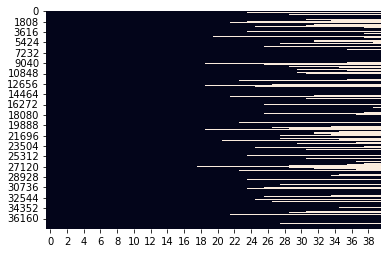

In [28]:
import seaborn as sns
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

### Prepare feature matrix for X_test

In [29]:
# create sequence of dictionary ids in place of words
lst_text2seq = tokenizer.texts_to_sequences(df_test.processed)
len(lst_text2seq)

16265

In [30]:
# padding sequence      
X_test = k_preprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=40, padding="post", truncating="post")
X_test

array([[  5246,    266,    234, ...,      0,      0,      0],
       [  2822,   9673,    789, ...,    435,    379,   1314],
       [  2331,   1102,  17367, ...,      0,      0,      0],
       ...,
       [  3282,   2711,    972, ...,      0,      0,      0],
       [  5014,     11,    412, ...,      0,      0,      0],
       [108487,      1,     95, ...,      0,      0,      0]])

In [31]:
X_test.shape

(16265, 40)

### Feature matrix for each sentence (i.e. lengths of sentences)

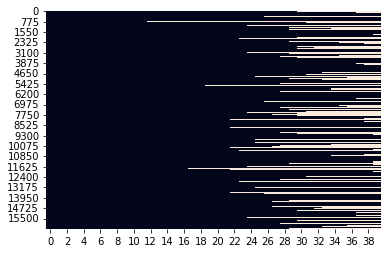

In [32]:
import seaborn as sns
sns.heatmap(X_test==0, vmin=0, vmax=1, cbar=False)
plt.show()

### Create the matrix of embedding (weight matrix)

In [33]:
import numpy as np

## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp.wv[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [34]:
idx = dic_vocabulary['dog']
embeddings[idx].shape

(300,)

## Prepare TF layers model

In [35]:
embeddings.shape

(110958, 300)

In [40]:
from tensorflow.keras import models, layers


def get_model(verbose = False):
    x_input_layer = layers.Input(shape=(40,))

    # embedding
    x_layers = layers.Embedding(input_dim=embeddings.shape[0],
                                output_dim=embeddings.shape[1],
                                weights=[embeddings],
                                input_length=40, trainable=False)(x_input_layer)

    # calculations
    x_layers = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                            return_sequences=True))(x_layers)
    x_layers = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x_layers)

    # activation

    x_layers = layers.Dense(64, activation='relu')(x_layers)
    y_out = layers.Dense(27, activation='softmax')(x_layers)

    # create model

    model = models.Model(x_input_layer, y_out)
    model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
    
    if verbose:
        model.summary()
    
    return model


## Encode categories

In [65]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

In [38]:
categories_dict = {label:n for n,label in 
                   enumerate(np.unique(df_train.genre))} # from training set

# map categories to numbers
y_train = np.array([categories_dict[y] for y in y_train])

In [39]:
y_train

array([5, 7, 7, ..., 7, 7, 8])

## Train model

In [52]:
from tensorflow.keras.models import load_model

training = None
model = None
load = False

#loading cell
if load:
    # load here
    model = load_model('keras_model')
else:
    model = get_model()
    training = model.fit(x=X_train, y=y_train, batch_size=256, 
                        epochs=30, shuffle=True, verbose=0, 
                        validation_split=0.3)
    model.save("keras_model")

INFO:tensorflow:Assets written to: keras_model\assets


INFO:tensorflow:Assets written to: keras_model\assets


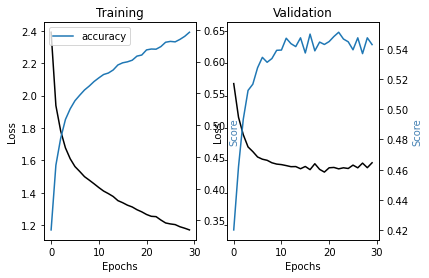

In [53]:
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

In [70]:
categories_dict_inversed = {v:k for k,v in categories_dict.items()}

In [73]:
## test
predicted_prob = model.predict(X_test)
predicted = [categories_dict_inversed[np.argmax(pred)] for pred in predicted_prob]

In [79]:
len(y_test)

16265

In [76]:
len(predicted)

16265

In [81]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, predicted)
print(conf_matrix)

[[ 168    1    6    0    0   44    1   28   66    0    0    1    0   11
     0    0    0    0    2    0   29    3   11    0   24    0    4]
 [   3   62   21    2    0   39    0    6   18    3    0    0    0    8
     1    0    0    0    1    0    0    4    0    0    4    0    0]
 [  16   19   39    3    0   24    0   28   36    3    0    0    0   18
     0    0    0    0    6    0   12    6    1    1    0    0    6]
 [  12    0   10   19    0   20    0   14   17   23    0    1    0    8
     0    0    0    0    3    1   11   15    0    0    1    0    1]
 [   1    0    0    0    0    1    0   47   25    1    0    0    0    1
     0    0    0    0    0    0    0    5    0    1    1    0    0]
 [  43   16   19   10    0 1426    0   92  423   17    0    5    0   41
     8    0    0    0   35    1    4   47    4    9   22    0    7]
 [  28    0    2    0    0   27    0   12   44    1    0    0    0    9
     0    0    0    0    0    0    1    3    0    0   29    0    1]
 [  48    1   10    

<AxesSubplot:>

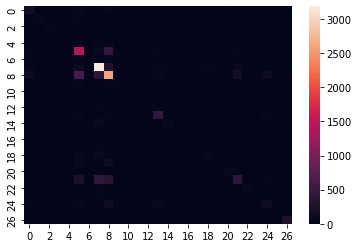

In [83]:
import seaborn as sb
sb.heatmap(conf_matrix)

# TEREN TESTOWY

In [28]:
from tensorflow.keras import preprocessing as k_preprocessing

# tokenize vocab
tokenizer = k_preprocessing.text.Tokenizer(lower=True, split=' ', oov_token="NaN", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(corpus_tokenized)
dic_vocabulary = tokenizer.word_index

In [29]:
print(len(dic_vocabulary.keys()))

for key in list(dic_vocabulary.keys())[1796:1797]:
    print(key, dic_vocabulary[key])


114428
nuclear 1797


## to jest git

In [30]:
# create sequence of dictionary ids in place of words
lst_text2seq = tokenizer.texts_to_sequences(df.desc_prepared) # albo w ogole mozna to zrobic na preprocessed bo i tak usuwa kropki i znaki, wtedy nie trzeba tego przygotowywac
len(lst_text2seq)

54214

In [31]:
lst_2 = tokenizer.texts_to_sequences(df.processed) # albo w ogole mozna to zrobic na preprocessed bo i tak usuwa kropki i znaki, wtedy nie trzeba tego przygotowywac
len(lst_2)

54214

In [32]:
test = tokenizer.texts_to_sequences(['man woman some#! kind   of  sentence'])
test

[[20, 17, 1, 623, 1, 2233]]

In [33]:
# padding sequence      
X_train = k_preprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=50, padding="post", truncating="post")
X_train

array([[ 4999,  1054,   281, ...,   394,  2192,  6746],
       [   69,   119,    92, ...,     0,     0,     0],
       [ 1461,  1801,   114, ...,   785, 10758,   103],
       ...,
       [28895, 69716, 69717, ...,     0,     0,     0],
       [ 2518, 14296,    63, ...,  1160,   269,   152],
       [ 2407,    22,  1013, ...,     0,     0,     0]])

In [34]:
X_train.shape

(54214, 50)

### Feature matrix for each sentence (i.e. lengths of sentences)

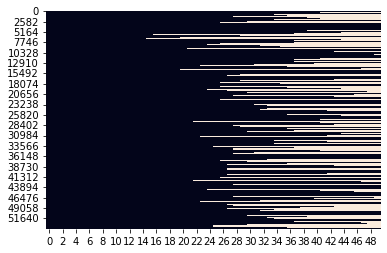

In [35]:
import seaborn as sns
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()